<a href="https://colab.research.google.com/github/TaviTragus/data-science-fundamentals/blob/main/Unit8/TaviTragU8Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unit 8 Project: Forest Fires#

##Introduction##

I was scrolling the UC Irvine Machine Learning Institute database (Kaggle but better) looking for a dataset when I came across this one. Its a list of wildfires that happened in Montesinho Natural Park (Canada) between January 2000 and December 2003, it includes measured data: area of the fire (hectares), temperature, wind, rain, relative humidity,and location in the park; the month the fire occured in; and predictors from the Canadian Wildland Fire Information System.

###Imports/Setup###

In [ ]:
!pip install preliz
!pip install ucimlrepo

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import seaborn as sns
from ucimlrepo import fetch_ucirepo

In [ ]:
!pip install pymc_bart

In [ ]:
import pymc_bart as pmb

##Data Setup/Wrangling##

Bless UC Irvine for just providing code to import as pandas dataframes. I combined the x and y dataframes, and then dropped any rows with a 0 for area because the model didn't like them (it refused to run, because dividing by 0 or something). Removing them is maybe a problem because it is about half of the dataset. However, we are looking at predicting the area of wildfires from weather data, so wildfires that have take up no area are less valuable to consider.

In [ ]:
# fetch dataset
forest_fires = fetch_ucirepo(id=162)

# data (as pandas dataframes)
x = forest_fires.data.features
y = forest_fires.data.targets
dat = pd.concat([x, y], axis = 1)
data = dat.query("area != 0") #drop all times where the fire burned no area, explain why in writeup

In [ ]:
dat

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [ ]:
data

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
138,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36
139,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43
140,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47
141,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55
142,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17
510,6,5,aug,fri,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,0.43
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29


In [ ]:
features = ["temp", "RH", "wind", "rain"]  #just using physical measured data, no month, location, or day of week
X = data[features]#.to_numpy().reshape(-1, 1)
Y = data["area"].to_numpy() #area in hectares

##First Model: Using temperature, wind, humidity, and rain, and a normal likelihood##

For my first model, I am just going with the model from the notes because it is very general. I chose all the physical predictors because

In [ ]:
with pm.Model() as model_fire_norm:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_fire_norm = pm.sample()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<Axes: xlabel='y'>

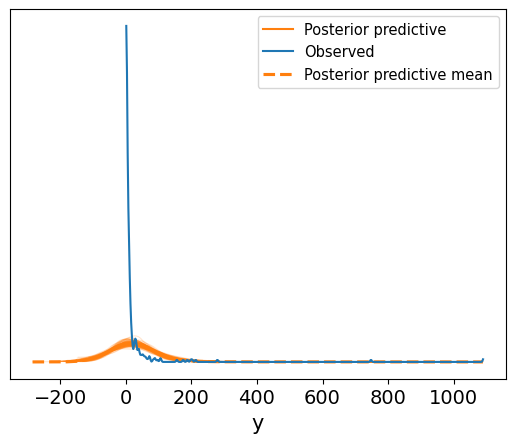

In [ ]:
pm.sample_posterior_predictive(idata_fire_norm,model_fire_norm, extend_inferencedata=True)
az.plot_ppc(idata_fire_norm, num_pp_samples=100, colors=["C1", "C0", "C1"])

##Model 2: same as before but exponential likelihood##

In [ ]:
with pm.Model() as model_fire_exp:
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    lm = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Exponential("y", lam=lm,  observed=Y)
    idata_fire_exp = pm.sample()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<Axes: xlabel='y'>

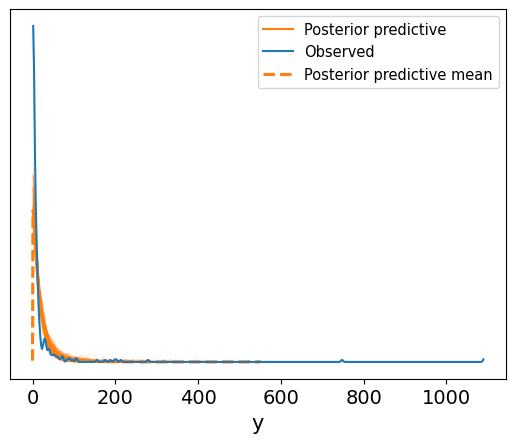

In [ ]:
pm.sample_posterior_predictive(idata_fire_exp,model_fire_exp, extend_inferencedata=True)
az.plot_ppc(idata_fire_exp, num_pp_samples=100, colors=["C1", "C0", "C1"])

In [ ]:
posterior_mean = idata_fire_exp.posterior["μ"]

μ_hdi = az.hdi(ary=idata_fire_exp, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_fire_exp, group="posterior_predictive", var_names=["y"]
).T

###physical###

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


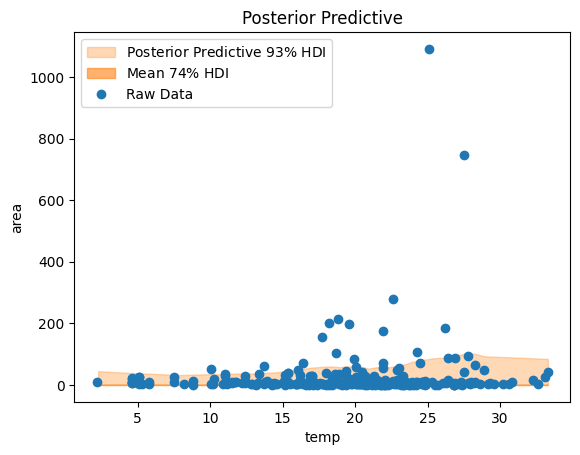

In [ ]:
idx = np.argsort(data["temp"])
fig, ax = plt.subplots()

az.plot_hdi(
    x=data["temp"],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=data["temp"],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(data["temp"], data["area"], "o", c="C0", label="Raw Data")
ax.legend(loc="upper left")
ax.set(
    title="Posterior Predictive",
    xlabel="temp",
    ylabel="area",
);

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


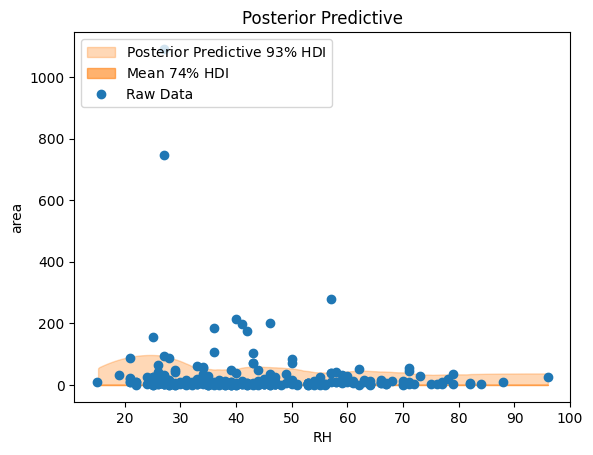

In [ ]:
idx = np.argsort(data["RH"])
fig, ax = plt.subplots()

az.plot_hdi(
    x=data["RH"],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=data["RH"],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(data["RH"], data["area"], "o", c="C0", label="Raw Data")
ax.legend(loc="upper left")
ax.set(
    title="Posterior Predictive",
    xlabel="RH",
    ylabel="area",
);

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


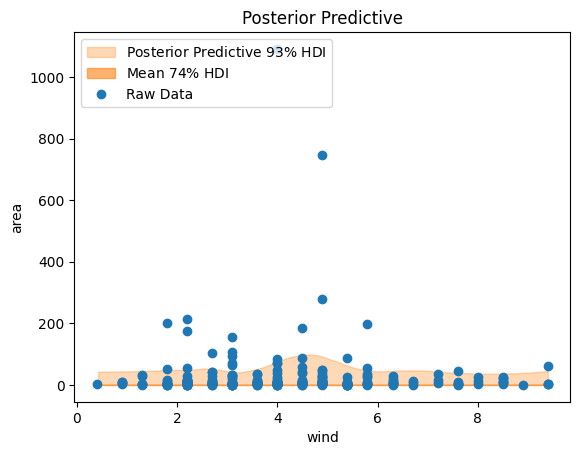

In [ ]:
idx = np.argsort(data["wind"])
fig, ax = plt.subplots()

az.plot_hdi(
    x=data["wind"],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=data["wind"],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(data["wind"], data["area"], "o", c="C0", label="Raw Data")
ax.legend(loc="upper left")
ax.set(
    title="Posterior Predictive",
    xlabel="wind",
    ylabel="area",
);

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


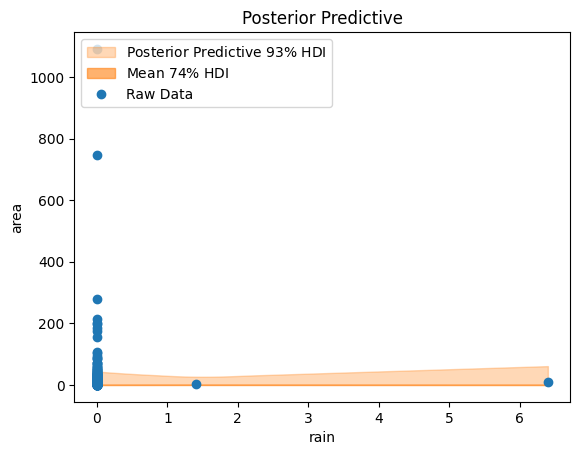

In [ ]:
idx = np.argsort(data["rain"])
fig, ax = plt.subplots()

az.plot_hdi(
    x=data["rain"],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=data["rain"],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(data["rain"], data["area"], "o", c="C0", label="Raw Data")
ax.legend(loc="upper left")
ax.set(
    title="Posterior Predictive",
    xlabel="rain",
    ylabel="area",
);

###pdp, ice, and vi###

/usr/local/lib/python3.11/dist-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


array([<Axes: xlabel='temp'>, <Axes: xlabel='RH'>, <Axes: xlabel='wind'>,
       <Axes: xlabel='rain'>], dtype=object)

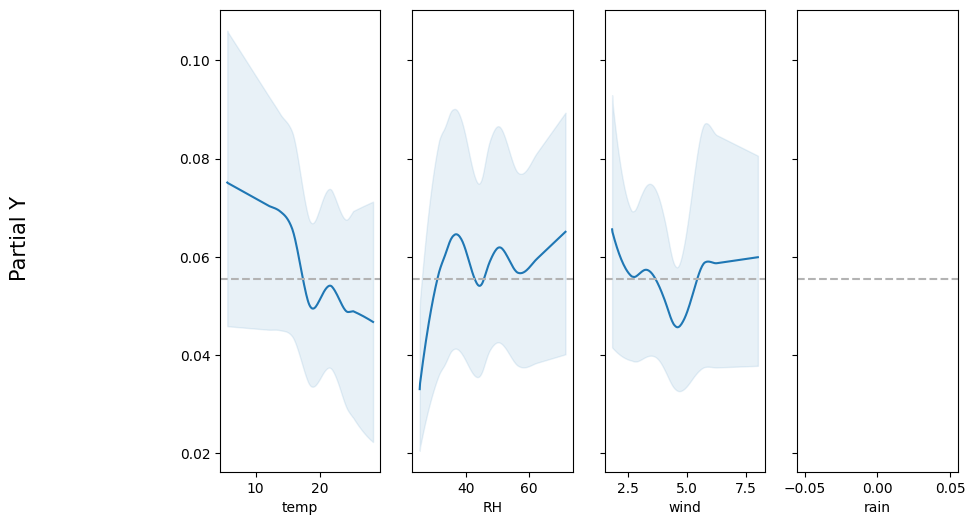

In [ ]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='temp'>, <Axes: xlabel='RH'>, <Axes: xlabel='wind'>,
       <Axes: xlabel='rain'>], dtype=object)

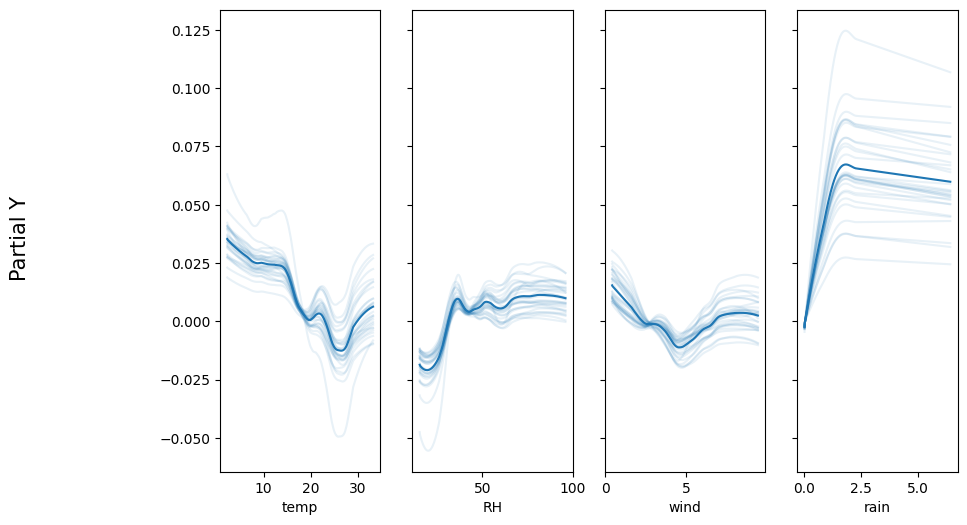

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

In [ ]:
vi_fire_exp = pmb.compute_variable_importance(idata_fire_exp, μ_, X)

<Axes: ylabel='R²'>

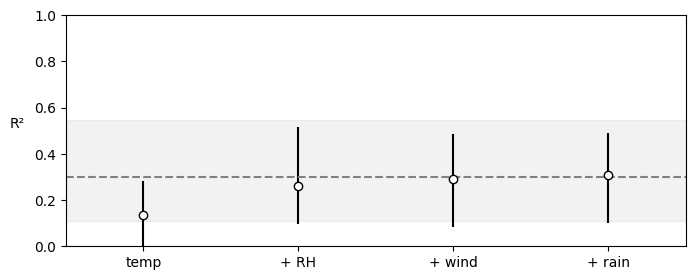

In [ ]:
pmb.plot_variable_importance(vi_fire_exp)

##Other stuff to come back to##

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

I think flipper length is the most important predictor for body mass. The pdp and ice plots both indicate that flipper length has a big impact on body weight. The ice plot is tightly grouped for all flipper length values, whereas it is spread out for higher bill length values and lower bill depth values. The variable importance chart shows that all variables are within acceptable R^2 values, but that bill length is the best. I still think due to the clearer trend in the ice plot and the physical necessity for larger flippers to move a larger penguin through the water, that flipper length is the most important predictor.  